In [1]:
import numpy as np
import pandas as pd
import empyrical as ep
import statsmodels.api as sm

import alphalens as al
from alphalens import plotting
import alphalens.performance as perf

from jqdata import *
from sqlalchemy.sql import func
from jqfactor import (Factor, calc_factors, neutralize,
                      standardlize, get_factor_values)

from functools import reduce
from tqdm import tqdm_notebook
from typing import (Tuple, List)
from dateutil.parser import parse

import seaborn as sns
import matplotlib.pyplot as plt


mpl.rcParams['font.family'] = 'serif'  # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

# 前言


若股票在某段上涨行情中出现了较长的上影线，则我们往往认为该股当前的**卖压**较大，空头势力占优，上涨行情即将结束。下图为上证指数在2019年4季度的某段行情走势，图中2019-10-14、2019-11-05、 2019-12-17这3根蜡烛线，均位于上涨行情中，但当日都出现了较长的上影线；果不其然，指数在未来几个交易日内均出现了较大幅度的下跌，如2019-10-14后的4个交易日，上证指数累计下跌2.32%。

In [44]:
# 蜡烛图

import matplotlib.dates as mdate
import matplotlib.ticker as ticker
from matplotlib.path import Path
from matplotlib.patches import PathPatch


# 画出蜡烛图
def plot_candlestick(df:pd.DataFrame,title:str='',**kwargs):
    '''
    画出蜡烛图
    -----------
        price:index-date columns-OHLC
                index为datetime
        kwargs:为pathpatch时则画出需要标记的k线
    '''

    df = df.copy()
    df.index.names = ['date']
    df = df.reset_index()
    data = df[['date','open','high','low','close']]


    # 生成横轴的刻度名字
    date_tickers = df['date'].dt.strftime('%Y-%m-%d').values

    day_quotes=[tuple([i]+list(quote[1:])) for i,quote in enumerate(data.values)]
    mpl.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(figsize=(18,4))
    plt.title(title)
    def format_date(x,pos=None):
        if x<0 or x>len(date_tickers)-1:
            return ''
        return date_tickers[int(x)]
    
    candlestick_ohlc(ax,day_quotes,colordown='g', colorup='r',width=0.2)
    
    if 'pathpatch' in kwargs:
        ax.add_patch(kwargs['pathpatch'])
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date));
    ax.grid(True)
    
# 标记需要标记的K线
def get_mark_data(price:pd.DataFrame,target_date:list):
    
    '''
    标记出k线
    -----------
        price:index-date columns-OHLC
            index为datetime
        target_date:list 日期格式yyyy-mm-dd
    '''
    
    df = price[['open','high','low','close']].copy()
    df.index = df.index.strftime('%Y-%m-%d')
    
    if isinstance(target_date,list):
        
        target_data = [target_date]

    vertices = []
    codes = []
    
    idx = [df.index.get_loc(i) for i in target_date]
    
    
    for i in idx:
        
        low = df['low'].iloc[i] * (1 - 0.001)
        high = df['high'].iloc[i] * (1 + 0.001)
        
        codes += [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
        vertices += [(i - 0.5, low), (i - 0.5, high), (i + 0.5, high), (i + 0.5, low), (i - 0.5, low)]

    path = Path(vertices, codes)
    pathpatch = PathPatch(path, facecolor='None', edgecolor='black',lw=2)
    
    return pathpatch

    
def candlestick_ohlc(ax, quotes, width=0.2, colorup='k', colordown='r',
                     alpha=1.0):
    """
    Plot the time, open, high, low, close as a vertical line ranging
    from low to high.  Use a rectangular bar to represent the
    open-close span.  If close >= open, use colorup to color the bar,
    otherwise use colordown
    Parameters
    ----------
    ax : `Axes`
        an Axes instance to plot to
    quotes : sequence of (time, open, high, low, close, ...) sequences
        As long as the first 5 elements are these values,
        the record can be as long as you want (e.g., it may store volume).
        time must be in float days format - see date2num
    width : float
        fraction of a day for the rectangle width
    colorup : color
        the color of the rectangle where close >= open
    colordown : color
         the color of the rectangle where close <  open
    alpha : float
        the rectangle alpha level
    Returns
    -------
    ret : tuple
        returns (lines, patches) where lines is a list of lines
        added and patches is a list of the rectangle patches added
    """
    return _candlestick(ax, quotes, width=width, colorup=colorup,
                        colordown=colordown,
                        alpha=alpha, ochl=False)


def _candlestick(ax, quotes, width=0.2, colorup='k', colordown='r',
                 alpha=1.0, ochl=True):
    """
    Plot the time, open, high, low, close as a vertical line ranging
    from low to high.  Use a rectangular bar to represent the
    open-close span.  If close >= open, use colorup to color the bar,
    otherwise use colordown
    Parameters
    ----------
    ax : `Axes`
        an Axes instance to plot to
    quotes : sequence of quote sequences
        data to plot.  time must be in float date format - see date2num
        (time, open, high, low, close, ...) vs
        (time, open, close, high, low, ...)
        set by `ochl`
    width : float
        fraction of a day for the rectangle width
    colorup : color
        the color of the rectangle where close >= open
    colordown : color
         the color of the rectangle where close <  open
    alpha : float
        the rectangle alpha level
    ochl: bool
        argument to select between ochl and ohlc ordering of quotes
    Returns
    -------
    ret : tuple
        returns (lines, patches) where lines is a list of lines
        added and patches is a list of the rectangle patches added
    """

    OFFSET = width / 2.0

    lines = []
    patches = []
    for q in quotes:
        if ochl:
            t, open, close, high, low = q[:5]
        else:
            t, open, high, low, close = q[:5]

        if close >= open:
            color = colorup
            lower = open
            height = close - open
        else:
            color = colordown
            lower = close
            height = open - close

        vline = Line2D(
            xdata=(t, t), ydata=(low, high),
            color=color,
            linewidth=0.5,
            antialiased=True,
        )

        rect = Rectangle(
            xy=(t - OFFSET, lower),
            width=width,
            height=height,
            facecolor=color,
            edgecolor=color,
        )
        rect.set_alpha(alpha)

        lines.append(vline)
        patches.append(rect)
        ax.add_line(vline)
        ax.add_patch(rect)
    ax.autoscale_view()

    return lines, patches


def _check_input(opens, closes, highs, lows, miss=-1):
    """Checks that *opens*, *highs*, *lows* and *closes* have the same length.
    NOTE: this code assumes if any value open, high, low, close is
    missing (*-1*) they all are missing
    Parameters
    ----------
    ax : `Axes`
        an Axes instance to plot to
    opens : sequence
        sequence of opening values
    highs : sequence
        sequence of high values
    lows : sequence
        sequence of low values
    closes : sequence
        sequence of closing values
    miss : int
        identifier of the missing data
    Raises
    ------
    ValueError
        if the input sequences don't have the same length
    """

    def _missing(sequence, miss=-1):
        """Returns the index in *sequence* of the missing data, identified by
        *miss*
        Parameters
        ----------
        sequence :
            sequence to evaluate
        miss :
            identifier of the missing data
        Returns
        -------
        where_miss: numpy.ndarray
            indices of the missing data
        """
        return np.where(np.array(sequence) == miss)[0]

    same_length = len(opens) == len(highs) == len(lows) == len(closes)
    _missopens = _missing(opens)
    same_missing = ((_missopens == _missing(highs)).all() and
                    (_missopens == _missing(lows)).all() and
                    (_missopens == _missing(closes)).all())

    if not (same_length and same_missing):
        msg = ("*opens*, *highs*, *lows* and *closes* must have the same"
               " length. NOTE: this code assumes if any value open, high,"
               " low, close is missing (*-1*) they all must be missing.")
        raise ValueError(msg)

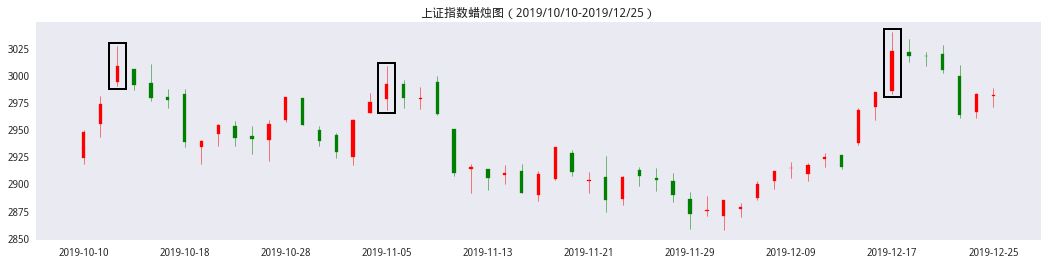

In [3]:
price = get_price('000001.XSHG','2019-10-10','2019-12-25')

plot_candlestick(price,'上证指数蜡烛图（2019/10/10-2019/12/25）',
                 pathpatch=get_mark_data(price,['2019-10-14','2019-11-05','2019-12-17']))

在传统技术指标中上下影线的定义如下：

$$上影线=High - Max(Close,Open)$$
$$下影线=Min(Close,Open) - Low$$

**传统蜡烛图以"Max(Open,Close)"为基准，认为"High-Max(Open,Close)"为卖压，"Min(Open,Close)-Low"为买气。**

除了蜡烛图上下影线之外，威廉指标(Larry Williams, 1973)也常被用来衡量市场的超买超卖现象，以一段时间内的空方力量(High－Close)与多空总力量(High －Low)之比，来研判市场的未来走势。威廉指标的具体计算公式为：

$$威廉指标=（High-Close）/(High-Low)$$

**而威廉指标以"Close"为基准，认为"High-Close"为卖压，"Close-Low"为买气。**

上证指数在2020-01-23的蜡烛线出现了较长的下影线，根据传统蜡烛图的分析方法，当日买气大于卖压，后市看涨；而根据威廉指标的定义，以收盘价为基准，当日"High-Close"远大于"Close-Low"，即卖压远超买气，后市应该看空。事实证明威廉指标的判断是正确的，在下一个交易日2020-02-03，上证指数大幅低开8.73%，日内虽然逐渐反弹上涨，但全天仍然下跌7.72%。再如2020-02-04的案例，根据蜡烛图的定义，上证指数当日上下影线的长度几乎相同，买气约等于卖压，未产生明显的择时信号；而在威廉指标看来，指数当日买气远大于卖压，后市强烈看涨。后续几个交易日，市场用“6连阳”的大幅上涨，再一次证明了威廉指标的判断更为准确。

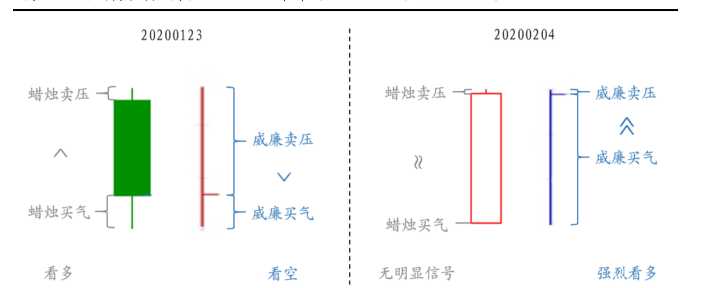

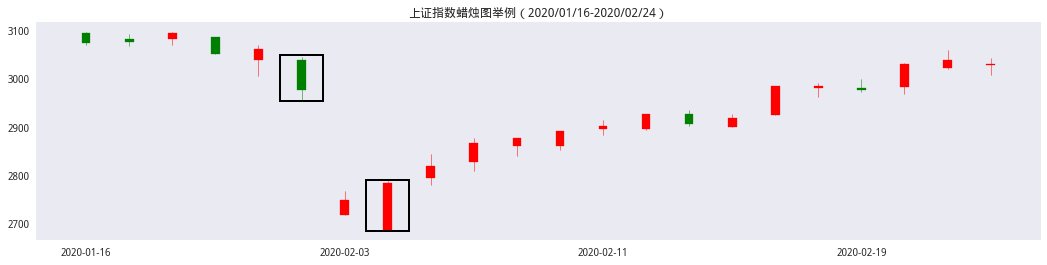

In [4]:
price = get_price('000001.XSHG','2020-01-16','2020-02-24',fields=['close','open','high','low'],panel=False)

plot_candlestick(price,'上证指数蜡烛图举例（2020/01/16-2020/02/24）',
                 pathpatch=get_mark_data(price,['2020-01-23','2020-02-04']))

In [5]:
# 画美国线
def plot_HLC_bar(df:pd.DataFrame,title:str='',**kwargs):
    
    '''
    画出蜡烛图
    -----------
        price:index-date columns-HLC
                index为datetime
        kwargs:为pathpatch时则画出需要标记的k线
    '''
    # 主体
    u_vertices1 = []
    u_codes1 = []
    
    # 辅
    u_codes2 = []
    u_vertices2 = []
    
    # 主题
    d_vertices1 = []
    d_codes1 = []
    
    # 辅
    d_codes2 = []
    d_vertices2 = []
    
    hlc = df.reset_index(drop=True)
    for idx,row in hlc.iterrows():
        
        low = row['low']
        high = row['high']
        close = row['close']
        open_ = row['open']
        
        
        if open_ < close:
            # 上涨部分
            u_codes1 += [Path.MOVETO] + [Path.LINETO] 
            u_codes2 += [Path.MOVETO] + [Path.LINETO]
            u_vertices1 += [(idx, low), (idx, high)]
            u_vertices2 += [(idx, close), (idx+0.2, close)]
        else:
            # 下跌部分
            d_codes1 += [Path.MOVETO] + [Path.LINETO]
            d_codes2 += [Path.MOVETO] + [Path.LINETO]
            d_vertices1 += [(idx, low), (idx, high)]
            d_vertices2 += [(idx, close), (idx+0.2, close)]
    
    # 上涨步伐
    path1 = Path(u_vertices1, u_codes1)
    path2 = Path(u_vertices2,u_codes2)
    
    bar1 = PathPatch(path1,lw=1.5,edgecolor='red')
    line1 = PathPatch(path2,lw=0.6,edgecolor='red')
    
    # 下跌部分
    path3 = Path(d_vertices1, d_codes1)
    path4 = Path(d_vertices2,d_codes2)
    
    bar2 = PathPatch(path3,lw=1.5,edgecolor='g')
    line2 = PathPatch(path4,lw=0.6,edgecolor='g')
    
    fig, ax = plt.subplots(figsize=(18,4))
    plt.title(title)
    ax.add_patch(bar1)
    ax.add_patch(line1)
    
    ax.add_patch(bar2)
    ax.add_patch(line2)
    ax.set_xlim(-0.5, len(df))
    ax.set_ylim(df['low'].min() * (1 - 0.01), df['high'].max() * (1 + 0.01))
    
    if 'pathpatch' in kwargs:
        ax.add_patch(kwargs['pathpatch'])
    
    def format_date(x,pos=None):
        if x<0 or x>len(date_tickers)-1:
            return ''
        return date_tickers[int(x)]
    
    date_tickers = df.index.strftime('%Y-%m-%d').values
    ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    ax.grid(True);

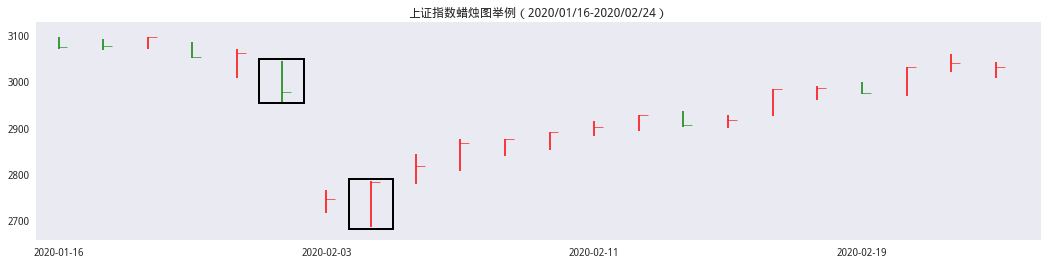

In [6]:
plot_HLC_bar(price,'上证指数蜡烛图举例（2020/01/16-2020/02/24）',
             pathpatch=get_mark_data(price,['2020-01-23','2020-02-04']))

# 因子构造


因子构造流程如下:

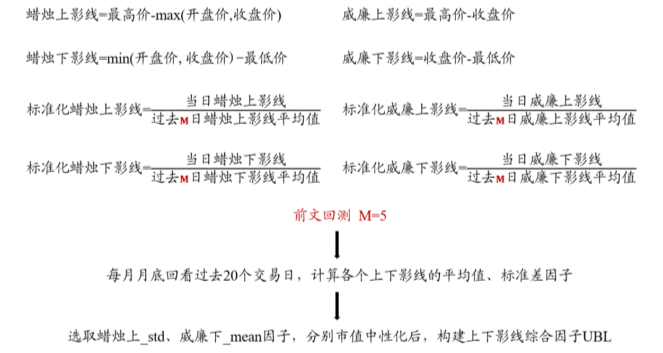

In [7]:

# 工具函数
def tdaysoffset(end_date: str, count: int) -> datetime.date:
    '''
    end_date:为基准日期
    count:为正则后推，负为前推
    -----------
    return datetime.date
    '''

    trade_date = get_trade_days(end_date=end_date, count=1)[0]

    if count > 0:
        # 将end_date转为交易日

        trade_cal = get_all_trade_days().tolist()

        trade_idx = trade_cal.index(trade_date)

        return trade_cal[trade_idx + count]

    elif count < 0:

        return get_trade_days(end_date=trade_date, count=abs(count))[0]

    else:

        raise ValueError('别闹！')

# 获取年末季末时点
def GetTradePeriod(start_date: str, end_date: str, freq: str = 'ME') -> list:
    '''
    start_date/end_date:str YYYY-MM-DD
    freq:M月，Q季,Y年 默认ME E代表期末 S代表期初
    ================
    return  list[datetime.date]
    '''
    days = pd.Index(pd.to_datetime(get_trade_days(start_date, end_date)))
    idx_df = days.to_frame()

    if freq[-1] == 'E':
        day_range = idx_df.resample(freq[0]).last()
    else:
        day_range = idx_df.resample(freq[0]).first()

    day_range = day_range[0].dt.date

    return day_range.dropna().values.tolist()

# 风险指标
def Strategy_performance(return_df: pd.DataFrame, periods='monthly') -> pd.DataFrame:
    '''计算风险指标 默认为月度:月度调仓'''

    ser: pd.DataFrame = pd.DataFrame()
    ser['年化收益率'] = ep.annual_return(return_df, period=periods)
    ser['波动率'] = return_df.apply(lambda x: ep.annual_volatility(x,period=periods))
    ser['夏普'] = return_df.apply(ep.sharpe_ratio, period=periods)
    ser['最大回撤'] = return_df.apply(lambda x: ep.max_drawdown(x))
    
    if 'benchmark' in return_df.columns:

        select_col = [col for col in return_df.columns if col != 'benchmark']

        ser['IR'] = return_df[select_col].apply(
            lambda x: information_ratio(x, return_df['benchmark']))
        ser['Alpha'] = return_df[select_col].apply(
            lambda x: ep.alpha(x, return_df['benchmark'], period=periods))

    return ser.T

def information_ratio(returns, factor_returns):
    """
    Determines the Information ratio of a strategy.

    Parameters
    ----------
    returns : :py:class:`pandas.Series` or pd.DataFrame
        Daily returns of the strategy, noncumulative.
        See full explanation in :func:`~empyrical.stats.cum_returns`.
    factor_returns: :class:`float` / :py:class:`pandas.Series`
        Benchmark return to compare returns against.

    Returns
    -------
    :class:`float`
        The information ratio.

    Note
    -----
    See https://en.wikipedia.org/wiki/information_ratio for more details.

    """
    if len(returns) < 2:
        return np.nan

    active_return = _adjust_returns(returns, factor_returns)
    tracking_error = np.std(active_return, ddof=1)
    if np.isnan(tracking_error):
        return 0.0
    if tracking_error == 0:
        return np.nan
    return np.mean(active_return) / tracking_error

def _adjust_returns(returns, adjustment_factor):
    """
    Returns a new :py:class:`pandas.Series` adjusted by adjustment_factor.
    Optimizes for the case of adjustment_factor being 0.

    Parameters
    ----------
    returns : :py:class:`pandas.Series`
    adjustment_factor : :py:class:`pandas.Series` / :class:`float`

    Returns
    -------
    :py:class:`pandas.Series`
    """
    if isinstance(adjustment_factor, (float, int)) and adjustment_factor == 0:
        return returns.copy()
    return returns - adjustment_factor

# 分组
def get_group(df:pd.DataFrame,target_factor:str,num_group:int=5)->pd.DataFrame:
    
    '''
    分组
    ----
        target_factor:目标列
        num_group:默认分5组
    '''
    df = df.copy()
    df = df.dropna(subset=[target_factor])
    label = ['G%s' % i for i in range(1, num_group+1)]
    df['group'] = df.groupby(level='date')[target_factor].transform(
    lambda x: pd.qcut(x.dropna(), 5, labels=label))
    
    return df

# 计算分组收益率
def get_algorithm_return(factor_df:pd.DataFrame)->pd.DataFrame:
    
    '''
    获取分组收益率
    ---------
        传入df数据结构
           ----------------------------------------------
                      |       |factor|group| next_return|
           ----------------------------------------------
               date   | asset |      |     |            |
           ----------------------------------------------
                      | AAPL  |  0.5 |  G1 |   0.23     |
                      -----------------------------------
                      | BA    | -1.1 |  G2 |   -0.7     |
                      -----------------------------------
           2014-01-01 | CMG   |  1.7 |  G2 |   0.023    |
                      -----------------------------------
                      | DAL   | -0.1 |  G3 |   -0.03    |
                      -----------------------------------
                      | LULU  |  2.7 |  G1 |   -0.21    |
                      -----------------------------------
    '''
    
    returns = pd.pivot_table(factor_df.reset_index(
    ), index='date', columns='group', values='next_ret')
    returns.columns = [str(i) for i in returns.columns]

    returns.index = pd.to_datetime(returns.index)
    
    return returns

# 画图 只能分五组
def plot_nav(nav: pd.DataFrame, title: str):
    '''
    画图
    ---------
        nav数据结构
        -------------------------------------
        |  date    | 1  | 2  | 3  | 4  | 5  |
        -------------------------------------
        |2020-01-01|0.01|0.02|0.14|-0.2|0.08|
        -------------------------------------
        |2020-01-02|0.11|-0.2|-0.1|0.33|0.10|
        -------------------------------------
    '''

    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(figsize=(18, 6))
    # 设置标题
    plt.title(title)
    # 1,5组设置不同的颜色和线型方便查看单调性
    ax.plot(nav['G1'], color='Navy')
    ax.plot(nav['G2'], color='LightGrey', ls='-.')
    ax.plot(nav['G3'], color='DimGray', ls='-.')
    ax.plot(nav['G4'], color='DarkKhaki', ls='-.')
    ax.plot(nav['G5'], color='LightSteelBlue')
        
    ax.axhline(1, color='black', lw=0.5)
    # 多空单独反应
    #ax1 = ax.twinx()
    ax.plot(nav['excess_ret'], color='r', ls='--')
    if 'benchmark' in nav.columns:
        ax.plot(nav['benchmark'],color='black',ls='--')
    #ax1.grid(None)
    # 图例合并
    h1, l1 = ax.get_legend_handles_labels()
    #h2, l2 = ax1.get_legend_handles_labels()
    #l2 = [l2[0] + '(right)']
    #ax.legend(h1+h2, l1+l2)
    ax.legend(h1,l1)
    
import scipy.stats as st

# 计算ic    
def information_table(ic_data:pd.DataFrame)->pd.DataFrame:
    '''计算IC'''
    ic_summary_table = pd.DataFrame()
    ic_summary_table["IC Mean"] = ic_data.mean()
    ic_summary_table["IC Std."] = ic_data.std()
    ic_summary_table["Risk-Adjusted IC"] = \
        ic_data.mean() / ic_data.std()
    t_stat, p_value = st.ttest_1samp(ic_data, 0)
    ic_summary_table["t-stat(IC)"] = t_stat
    ic_summary_table["p-value(IC)"] = p_value
    ic_summary_table["IC Skew"] = st.skew(ic_data)
    ic_summary_table["IC Kurtosis"] = st.kurtosis(ic_data)
    
    return ic_summary_table.T

In [8]:
# 获取股票池
def get_stockpool(symbol: str, watch_date: str) -> list:
    '''获取股票池'''

    if symbol == 'A':
        stockList = get_index_stocks('000002.XSHG', date=watch_date) + get_index_stocks(
            '399107.XSHE', date=watch_date)
    else:
        stockList = get_index_stocks(symbol, date=watch_date)
    stockList = del_st_stock(stockList, watch_date)  # 过滤ST
    stockList = del_iponday(stockList, watch_date)   # 过滤上市不足60日
    stockList = del_pause(stockList,watch_date)      # 过滤当日停牌的股票
    return stockList

def del_st_stock(securities: list, watch_date: str) -> list:
    '''过滤ST股票'''

    info_ser = get_extras('is_st', securities,
                          end_date=watch_date, df=True, count=1).iloc[0]

    return info_ser[info_ser == False].dropna().index.tolist()

def del_iponday(securities: list, watch_date: str, N: int = 60) -> list:
    '''返回上市大于N日的股票'''
    dic = {x: get_security_info(x, date=watch_date).start_date for x in securities if get_security_info(
        x, date=watch_date) != None}
    return [code for code, start_date in dic.items() if (parse(watch_date).date() - start_date).days > N]

def del_pause(securities:list,watch_date:str,N:int=1)->list:
    
    '''
    过滤停牌股,默认为过滤当日停牌的
    '''
    
    paused = get_price(securities,end_date=watch_date,count=N,fields='paused',panel=False)
    
    if N == 1:
        return paused.query('paused != 1')['code'].values.tolist()
    else:
        
        paused_num = paused.groupby('code')['paused'].sum()
        return paused_num[paused_num < N]['code'].values.tolist()

In [9]:
# 因子计算
def prepare_data(symbol: str, start: str, end: str, last_date: str, factor_list: list,offset:int=20) -> pd.DataFrame:
    '''
    symbol:股票池所属成份，A为全市场
    start,end:回测区间 频率为月度
    last_date:计算next_returns的最后一日的日期
    factor:构建的因子
    '''
    periods = GetTradePeriod(start, end, 'ME') # 月度_周期获取
    periods = periods + [last_date] 
    factor_dic = {}

    factor_names = [factor.__name__ for factor in factor_list]
    target_factor = [factor() for factor in factor_list]

    for tradeDate, nextDate in tqdm_notebook(zip(periods[:-1], periods[1:]), total=len(periods)-1, desc='因子计算'):
        
        # 股票池
        stock_pool = get_stockpool(symbol, tradeDate.strftime('%Y-%m-%d'))
    
        # 因子获取
        begin = tdaysoffset(tradeDate,-20)
        factor = calc_factors(
            stock_pool, target_factor, start_date=begin, end_date=tradeDate)
        
        factor_frame = pd.concat((calcDailyFactor(factor,i) for i in factor_names),axis=1)
        
        # 计算下期收益率
        close = get_price(stock_pool, end_date=tradeDate, count=1,
                          fields='close', panel=False).set_index('code')
        
        next_close = get_price(stock_pool, end_date=nextDate,
                               count=1, fields='close', panel=False).set_index('code')

        next_returns = next_close['close'] / close['close'] - 1
        next_returns.name = 'next_ret'
        
        # 合并
        tmp = pd.concat((factor_frame, next_returns), axis=1)
        factor_dic[tradeDate] = tmp # 放入容器

    factor_df = pd.concat(factor_dic)

    factor_df.index.names = ['date', 'code']
    
    return factor_df


def dict2frame(dic: dict) -> pd.DataFrame:
    
    '''将data的dict格式转为df'''

    df = pd.concat(tuple(df.iloc[-1] for df in dic.values()), axis=1)
    df.columns = list(dic.keys())
    return df

In [10]:
# 因子定义
class Upper_shadow(Factor):
    
    '''标准化上影线'''
    import warnings
    warnings.filterwarnings("ignore")

    name = 'Upper_shadow'
    max_window = 6
    dependencies = ['close','open','high']
    
    def calc(self,data)->pd.Series:
        
        high = data['high']
        open_ = data['open']
        close = data['close']
        
        upperShadow = high - np.maximum(close,open_)
        std_upperShadow = upperShadow / upperShadow.rolling(5).mean().shift(1)
        
        return std_upperShadow.iloc[-1]
    
class Lower_shadow(Factor):
    
    '''标准化下影线'''
    import warnings
    warnings.filterwarnings("ignore")

    name = 'Lower_shadow'
    max_window = 6
    dependencies = ['close','open','low']
    
    def calc(self,data)->pd.Series:
        
        low = data['low']
        open_ = data['open']
        close = data['close']
        
        lowerShadow = np.minimum(close,open_) - low
        std_lowerShadow = lowerShadow / lowerShadow.rolling(5).mean().shift(1)
        return std_lowerShadow.iloc[-1] 

    
class Williams_upper_shadow(Factor):
    
    '''威廉标准化上影线'''
    import warnings
    warnings.filterwarnings("ignore")

    name = 'Williams_upper_shadow'
    max_window = 6
    dependencies = ['close','high']
    
    def calc(self,data)->pd.Series:
        
        high = data['high']
        close = data['close']
        
        upperShadow = high - close
        std_upperShadow = upperShadow / upperShadow.rolling(5).mean().shift(1)
        
        return std_upperShadow.iloc[-1]
    
class Williams_lower_shadow(Factor):
    
    '''威廉标准化下影线'''
    import warnings
    warnings.filterwarnings("ignore")

    name = 'Williams_lower_shadow'
    max_window = 6
    dependencies = ['close','low']
    
    def calc(self,data)->pd.Series:
        
        low = data['low']
        close = data['close']
        
        lowerShadow = close - low
        std_lowerShadow = lowerShadow / lowerShadow.rolling(5).mean().shift(1)
        return std_lowerShadow.iloc[-1] 

    
def calcDailyFactor(factor_dic:dict,key:str)->Tuple[pd.Series,pd.Series]:
    '''计算当日因子'''
    df = factor_dic[key]

    ser1 = df.mean()
    ser1.name = key + '_mean'
    
    ser2 = df.std()
    ser2.name = key + '_std'
    
    return pd.concat((ser1,ser2),axis=1)


def add_benchmark(factor:pd.DataFrame,benchmark:str,col_name:str)->pd.DataFrame:
    
    '''获取因子分组收益与基准收益'''
    
    group_df = get_group(factor,col_name) # 因子升序排列
    returns = get_algorithm_return(group_df)

    begin = returns.index.min()
    end = returns.index.max()
    benchmark = get_price(benchmark, begin,end, fields='close')
    benchmark = benchmark.reindex(returns.index)
    benchmark = benchmark['close'].pct_change().fillna(0)
    returns['benchmark'] = benchmark

    returns['excess_ret'] = returns['G1'] - returns['G5']
    cum_df = np.exp(np.log1p(returns).cumsum())

    return cum_df

## 传统上下影线因子

- 选股空间:全部A股
    - 筛选规则:删除其中的ST,停牌股以及上市不足60日的次新股
- 频率:月度


**上下影线因子构造**

1. 每个交易日,计算每只股票当日的上、下影线,并做标准化:
$$蜡烛图上影线=HIGH-MAX(OPEN,CLOSE)$$
$$蜡烛图下影线=MIN(OPEN,CLOSE)-LOW$$
$$标准化蜡烛图上(下)影线=\frac{当日上(下)影线}{过去五日上(下)影线的平均值}$$
2. 每月月底,回溯过去20个交易日,每只股票都计算其每日标准化蜡烛上影线的平均值、标准差,得到两个因子，分别简称**Upper_shadow_mean、Upper_shadow_std**,代表了蜡烛图上下影线中蕴藏的选股信息;同样计算其下影线因子简称为**Lower_shadow_mean、Lower_shadow_std**
3. 因子值从小到大排序,分为5组

In [11]:
# 上下影线因子
factor_normal = prepare_data('A','2013-01-01','2020-12-31','2021-01-31',[Upper_shadow,Lower_shadow],20)

factor_normal = factor_normal.replace(np.inf,np.nan)
factor_normal.head()

Upper_shadow_mean    ...     next_ret
date       code                              ...             
2013-01-31 600000.XSHG           1.136415    ...    -0.037225
           600004.XSHG           0.942697    ...    -0.016317
           600005.XSHG           1.410016    ...    -0.037671
           600006.XSHG           1.415024    ...    -0.016556
           600007.XSHG           1.012155    ...     0.027383

[5 rows x 5 columns]

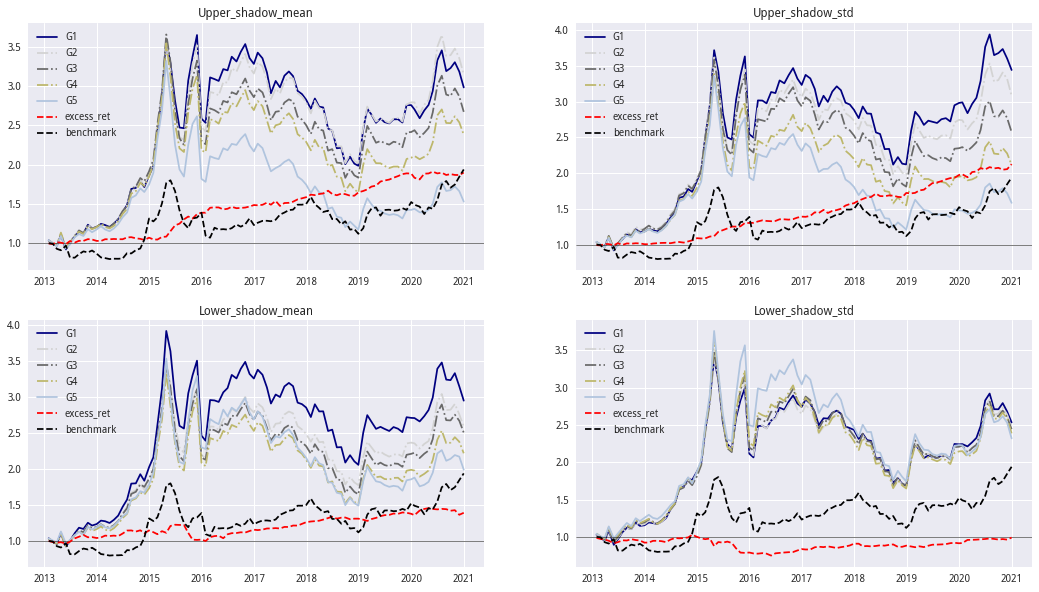

In [12]:
# 画图
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
col_name = [col for col in factor_normal.columns if col != 'next_ret']
# 净值情况
factorCumList = [add_benchmark(factor_normal, '000300.XSHG', col) for col in col_name]

idx = 0

for i in range(2):
    for j in range(2):
        nav = factorCumList[idx]
        ax = axes[i, j]
        # 设置标题
        ax.set_title(col_name[idx])
        # 1,5组设置不同的颜色和线型方便查看单调性
        ax.plot(nav['G1'], color='Navy')
        ax.plot(nav['G2'], color='LightGrey', ls='-.')
        ax.plot(nav['G3'], color='DimGray', ls='-.')
        ax.plot(nav['G4'], color='DarkKhaki', ls='-.')
        ax.plot(nav['G5'], color='LightSteelBlue')

        ax.axhline(1, color='black', lw=0.5)
        # 多空单独反应
        ax.plot(nav['excess_ret'], color='r', ls='--')
        ax.plot(nav['benchmark'], color='black', ls='--')
        ax.legend()
        idx += 1

In [13]:
# 多空组合风险指标
excess_df = pd.concat((df['excess_ret'] if idx != 3 else df[[
                      'excess_ret', 'benchmark']] for idx, df in enumerate(factorCumList)), axis=1)

excess_df.columns = col_name + ['benchmark']
excess_df = excess_df.pct_change()
(Strategy_performance(excess_df).style.format('{:.2%}')
                                      .set_caption('多空组合风险指标'))

,Upper_shadow_mean,Upper_shadow_std,Lower_shadow_mean,Lower_shadow_std,benchmark
年化收益率,8.38%,9.98%,4.20%,0.07%,8.63%
波动率,6.49%,5.15%,8.37%,8.10%,23.21%
夏普,128.94%,189.98%,53.94%,4.96%,47.58%
最大回撤,-4.12%,-2.98%,-18.41%,-27.09%,-40.56%
IR,-3.11%,-1.54%,-7.65%,-12.18%,nan%
Alpha,8.75%,9.73%,4.51%,0.73%,nan%


In [14]:
# 上下影线ic
normal_factorIc_list = [perf.factor_information_coefficient(factor_normal[[col, 'next_ret']].rename(
    columns={col: 'factor', 'next_ret': 22}).dropna()) for col in col_name]
normal_factorIc_df = pd.concat((information_table(ic) for ic in normal_factorIc_list),axis=1)
normal_factorIc_df.columns = col_name
normal_factorIc_df.style.format('{:.4f}')

,Upper_shadow_mean,Upper_shadow_std,Lower_shadow_mean,Lower_shadow_std
IC Mean,-0.0328,-0.0349,-0.0243,-0.0091
IC Std.,0.0645,0.0531,0.0718,0.0699
Risk-Adjusted IC,-0.5092,-0.6567,-0.3385,-0.1305
t-stat(IC),-4.9893,-6.4342,-3.3170,-1.2785
p-value(IC),0.0000,0.0000,0.0013,0.2042
IC Skew,-0.0016,-0.0288,0.1164,0.3217
IC Kurtosis,-0.5235,-0.3645,1.7796,0.3944


Upper_shadow_std因子的多空收益率最高且第一组(因子值最低的一组)净值最好,查看其2020-11-30日这期的因子值前5的股票形态。由上面的净值图可以看出2020年该因子收益率处于下降的状态,从K型形态也可看出,未来一个月的预测能力为负。

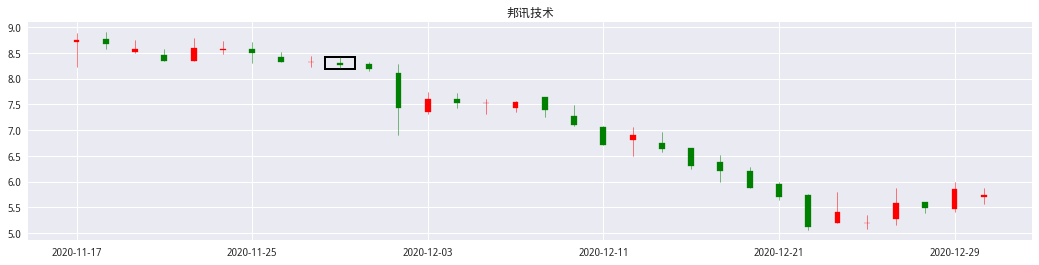

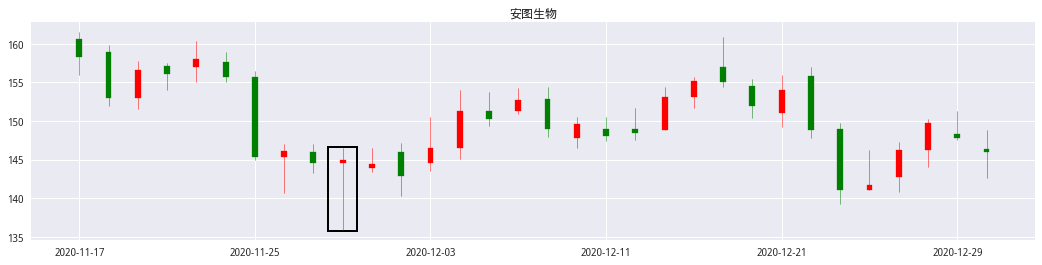

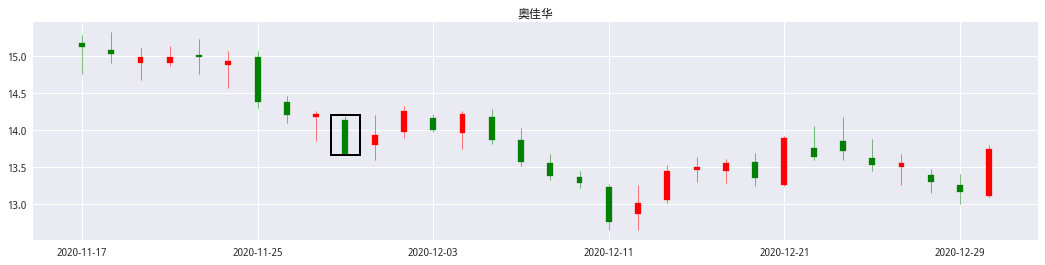

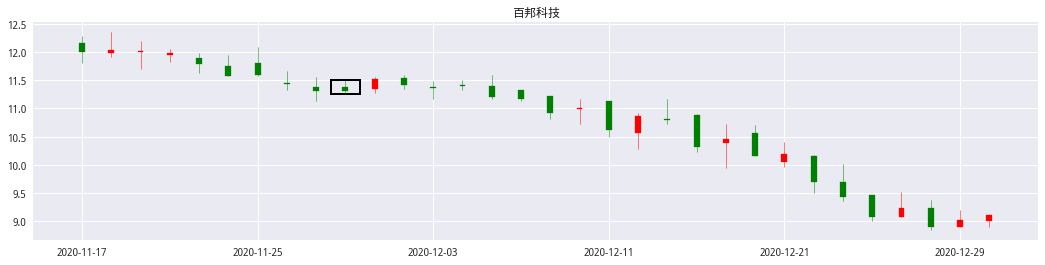

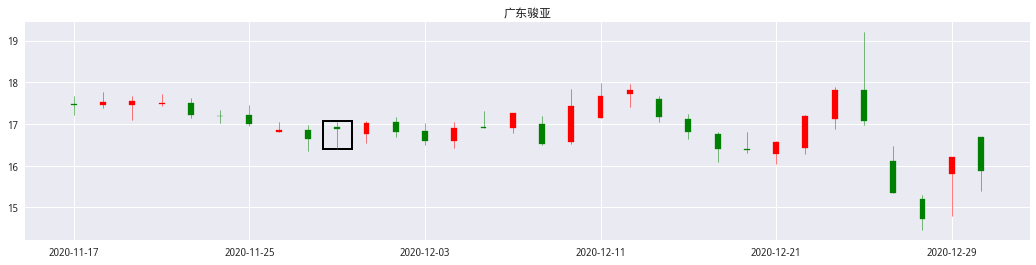

In [51]:
# 查看因子值最小的5只股票在因子计算日当日的K线形态
watch_date = datetime.date(2020,11,30)
target_col = 'Upper_shadow_std'
stocks = factor_normal.loc[watch_date,target_col].nsmallest(5).index.tolist()

beginDt = tdaysoffset(watch_date,-10)
endDt = tdaysoffset(watch_date,22) # 查看之后一个月的走向

for code in stocks:
    price = get_price(code,beginDt,endDt,fields=['close','open','high','low'],panel=False)
    code_name = get_security_info(code).display_name
    plot_candlestick(price,code_name,
                     pathpatch=get_mark_data(price,[watch_date.strftime('%Y-%m-%d')]))

## 威廉上下影线因子

- 选股空间:全部A股
    - 筛选规则:删除其中的ST,停牌股以及上市不足60日的次新股
- 频率:月度


**威廉上下影线因子构造**

1. 每个交易日,计算每只股票当日的上、下影线,并做标准化:
$$威廉上影线=HIGH-CLOSE$$
$$威廉下影线=CLOSE-LOW$$
$$标准化威廉上(下)影线=\frac{当日上(下)影线}{过去五日上(下)影线的平均值}$$
2. 每月月底,回溯过去20个交易日,每只股票都计算其每日标准化蜡烛上影线的平均值、标准差,得到两个因子，分别简称**Williams_upper_shadow_mean、Williams_upper_shadow_std**,代表了蜡烛图上下影线中蕴藏的选股信息;同样计算其下影线因子简称为**Williams_lower_shadow_mean、Williams_lower_shadow_std**
3. 因子值从小到大排序,分为5组

In [15]:
# 威廉上下影线因子
factor_williams = prepare_data('A', '2013-01-01', '2020-12-31',
                               '2021-01-31', [Williams_upper_shadow, Williams_lower_shadow], 20)

factor_williams = factor_williams.replace(np.inf, np.nan)
factor_williams.head()

Williams_upper_shadow_mean    ...     next_ret
date       code                                       ...             
2013-01-31 600000.XSHG                    1.082248    ...    -0.037225
           600004.XSHG                    1.148430    ...    -0.016317
           600005.XSHG                    1.199239    ...    -0.037671
           600006.XSHG                    1.551124    ...    -0.016556
           600007.XSHG                    1.155262    ...     0.027383

[5 rows x 5 columns]

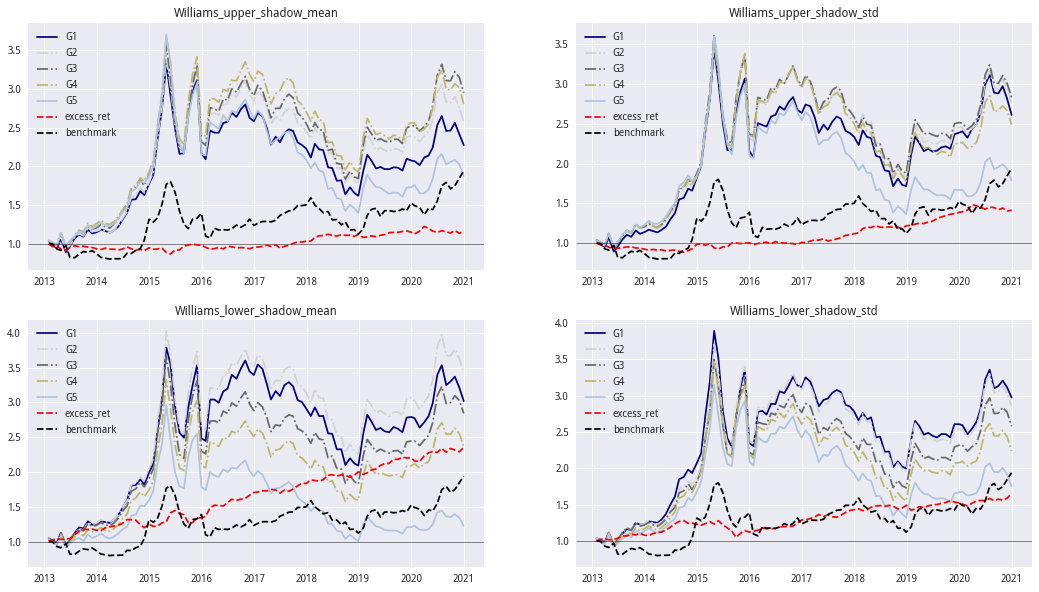

In [16]:
# 画图
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
col_name1 = [col for col in factor_williams.columns if col != 'next_ret']
# 净值情况
factorCumList1 = [add_benchmark(factor_williams, '000300.XSHG', col) for col in col_name1]

idx = 0

for i in range(2):
    for j in range(2):
        nav = factorCumList1[idx]
        ax = axes[i, j]
        # 设置标题
        ax.set_title(col_name1[idx])
        # 1,5组设置不同的颜色和线型方便查看单调性
        ax.plot(nav['G1'], color='Navy')
        ax.plot(nav['G2'], color='LightGrey', ls='-.')
        ax.plot(nav['G3'], color='DimGray', ls='-.')
        ax.plot(nav['G4'], color='DarkKhaki', ls='-.')
        ax.plot(nav['G5'], color='LightSteelBlue')

        ax.axhline(1, color='black', lw=0.5)
        # 多空单独反应
        ax.plot(nav['excess_ret'], color='r', ls='--')
        ax.plot(nav['benchmark'], color='black', ls='--')
        ax.legend()
        idx += 1

In [17]:
# 多空组合风险指标
excess_df1 = pd.concat((df['excess_ret'] if idx != 3 else df[[
                      'excess_ret', 'benchmark']] for idx, df in enumerate(factorCumList1)), axis=1)

excess_df1.columns = col_name1 + ['benchmark']
excess_df1 = excess_df1.pct_change()
(Strategy_performance(excess_df1).style.format('{:.2%}')
                                      .set_caption('多空组合风险指标'))

,Williams_upper_shadow_mean,Williams_upper_shadow_std,Williams_lower_shadow_mean,Williams_lower_shadow_std,benchmark
年化收益率,1.91%,4.41%,11.18%,6.53%,8.63%
波动率,7.80%,6.36%,8.64%,7.39%,23.21%
夏普,28.33%,71.92%,128.64%,90.36%,47.58%
最大回撤,-12.98%,-11.41%,-12.04%,-18.04%,-40.56%
IR,-9.96%,-7.81%,0.09%,-5.45%,nan%
Alpha,2.78%,4.50%,10.55%,6.08%,nan%


In [53]:
# 威廉上下影线ic
williams_factorIc_list = [perf.factor_information_coefficient(factor_williams[[col, 'next_ret']].rename(
    columns={col: 'factor', 'next_ret': 22}).dropna()) for col in col_name1]
williams_factorIc_df = pd.concat((information_table(ic) for ic in williams_factorIc_list),axis=1)
williams_factorIc_df.columns = col_name1
williams_factorIc_df.style.format('{:.4f}')

,Williams_upper_shadow_mean,Williams_upper_shadow_std,Williams_lower_shadow_mean,Williams_lower_shadow_std
IC Mean,-0.0131,-0.0161,-0.0487,-0.0336
IC Std.,0.0795,0.0665,0.0775,0.0720
Risk-Adjusted IC,-0.1645,-0.2421,-0.6286,-0.4663
t-stat(IC),-1.6114,-2.3723,-6.1589,-4.5687
p-value(IC),0.1104,0.0197,0.0000,0.0000
IC Skew,-0.0606,-0.1354,-0.0816,0.8130
IC Kurtosis,-0.6507,-0.2069,1.5998,1.0376


Williams_lower_shadow_mean因子的多空收益率最高且第一组(因子值最低的一组)净值最好,查看其2020-11-30日这期的因子值前5的股票形态。

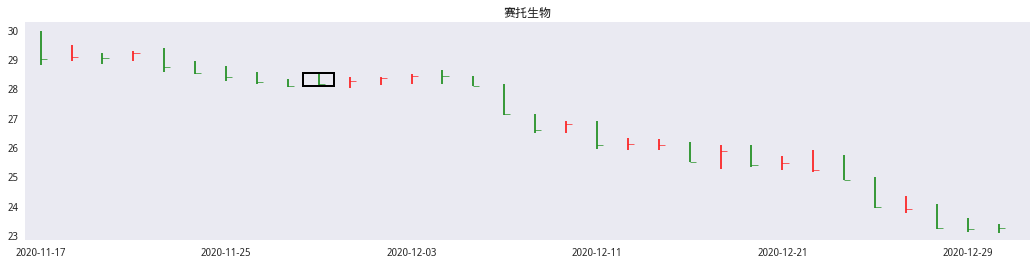

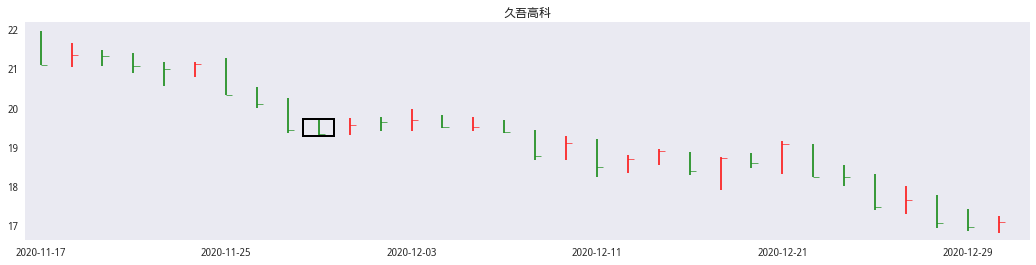

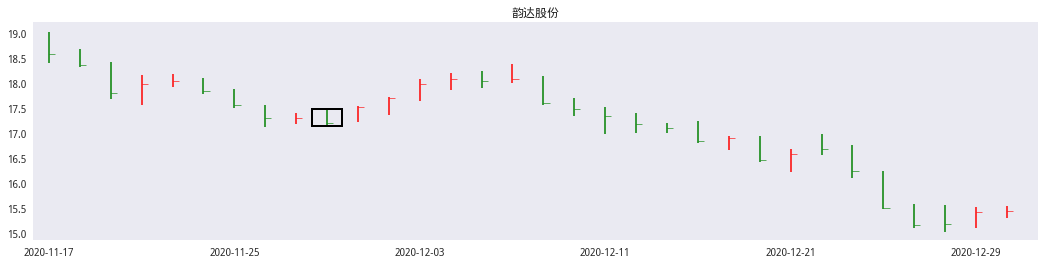

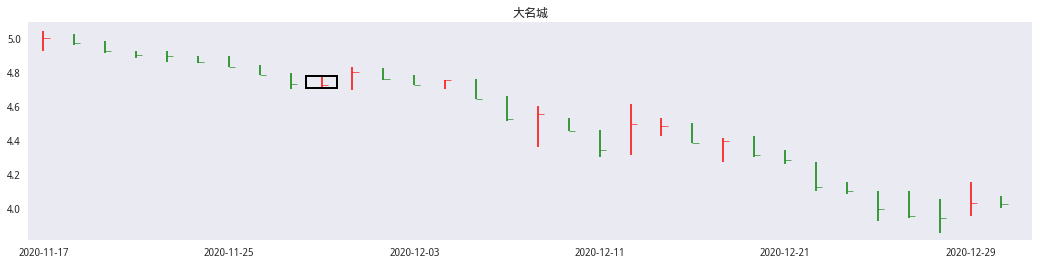

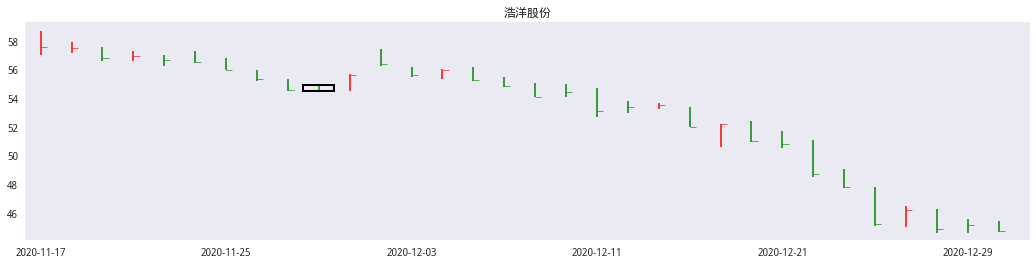

In [56]:
# 查看因子值最小的5只股票在因子计算日当日的K线形态
watch_date = datetime.date(2020,11,30)
target_col = 'Williams_lower_shadow_mean'
stocks = factor_williams.loc[watch_date,target_col].nsmallest(5).index.tolist()

beginDt = tdaysoffset(watch_date,-10)
endDt = tdaysoffset(watch_date,22) # 查看之后一个月的走向

for code in stocks:
    price = get_price(code,beginDt,endDt,fields=['close','open','high','low'],panel=False)
    code_name = get_security_info(code).display_name
    plot_HLC_bar(price,code_name,
                     pathpatch=get_mark_data(price,[watch_date.strftime('%Y-%m-%d')]))

## 上下影线综合因子UBL

由上我们可以看到多空因子收益中Upper_shadow_std,Williams_lower_shadow_mean这两个组合的收益是在同类型中收益最高的。由此我们选择这两个因子用于构建UBL因子：

1. 每月月底，分别将所有股票的Upper_shadow_std,Williams_lower_shadow_mean做市值中性化处理;
2. 将步骤1)处理过的因子分别做横截面标准化,将得到的结果记为Upper_shadow_std_desize、Williams_lower_shadow_mean_desize;
3. 等权线性相加得到上下影线综合因子 UBL（Up and Bottom Shadow Line），即:
$$UBL = Upper\_shadow\_std\_desize + Williams\_lower\_shadow\_mean\_desize$$

In [19]:
def get_desize(ser:pd.Series,date:str)->pd.Series:
    
    # 中性化
    ser_neutralize = neutralize(ser,date=date,how='market_cap',axis=0)
    # 标准化
    ser_standardlize = standardlize(ser_neutralize,inf2nan=True,axis=0)
    
    return ser_standardlize

In [20]:
# 中性化、标准化处理因子
Upper_shadow_std_desize = factor_normal.groupby(level='date')['Upper_shadow_std'].apply(
    lambda x: get_desize(x.reset_index(level=0, drop=True), date=x.name))

Williams_lower_shadow_mean_desize = factor_williams.groupby(level='date')['Williams_lower_shadow_mean'].apply(
    lambda x: get_desize(x.reset_index(level=0, drop=True), date=x.name))

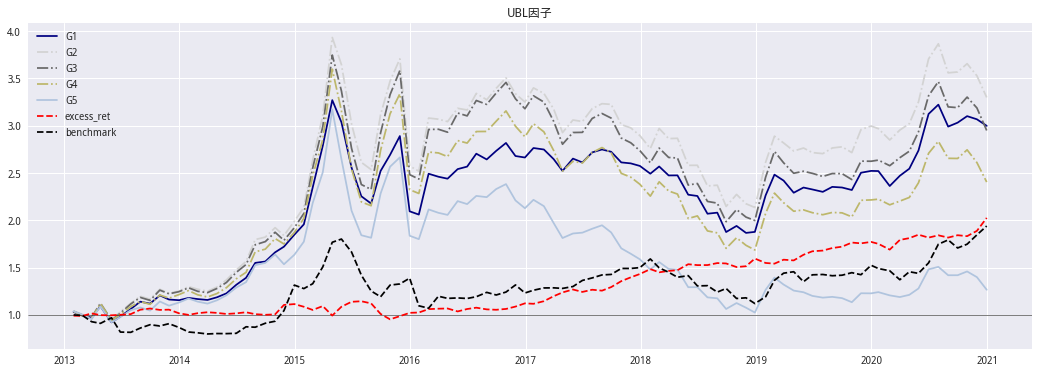

In [21]:
# 采用等权方式构造UBL因子
UBL = Upper_shadow_std_desize + Williams_lower_shadow_mean_desize

UBL_df = UBL.to_frame('UBL')
UBL_df['next_ret'] = factor_normal['next_ret']

# 因子净值
ublCum = add_benchmark(UBL_df,'000300.XSHG','UBL')
plot_nav(ublCum,'UBL因子')

In [22]:
# UBL因子风险指标
(Strategy_performance(ublCum.pct_change()).style.format('{:.2%}')
                                      .set_caption('多空组合风险指标'))

,G1,G2,G3,G4,G5,benchmark,excess_ret
年化收益率,14.27%,15.48%,13.95%,11.09%,2.50%,8.63%,9.33%
波动率,26.33%,30.35%,30.87%,30.98%,31.45%,23.21%,10.63%
夏普,64.56%,63.12%,58.16%,49.70%,23.50%,47.58%,90.42%
最大回撤,-42.90%,-45.68%,-47.01%,-53.12%,-67.67%,-40.56%,-16.70%
IR,5.46%,6.73%,5.64%,3.54%,-2.93%,nan%,-1.63%
Alpha,14.54%,16.61%,15.47%,12.92%,5.03%,nan%,9.51%


In [23]:
# UBL因子ic
ic = perf.factor_information_coefficient(UBL_df.rename(
    columns={'UBL': 'factor', 'next_ret': 22}).dropna())
ublIc_df = information_table(ic)

ublIc_df.style.format('{:.4f}')

,22
IC Mean,-0.0439
IC Std.,0.0919
Risk-Adjusted IC,-0.4774
t-stat(IC),-4.6772
p-value(IC),0.0000
IC Skew,0.3963
IC Kurtosis,0.2662


UBL因子的多空收益率最高且第一组(因子值最低的一组)净值最好,查看其2020-11-30日这期的因子值前5的股票形态。

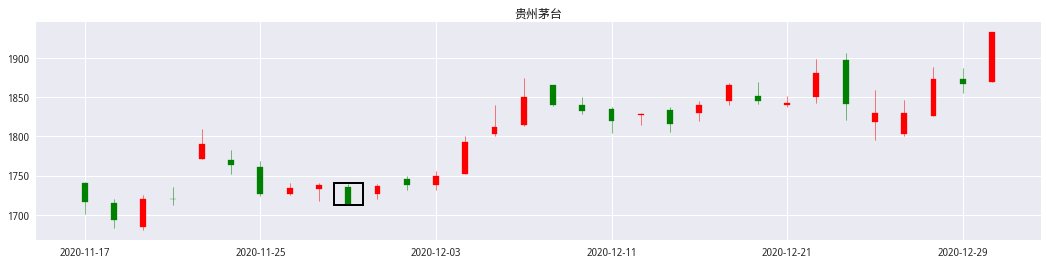

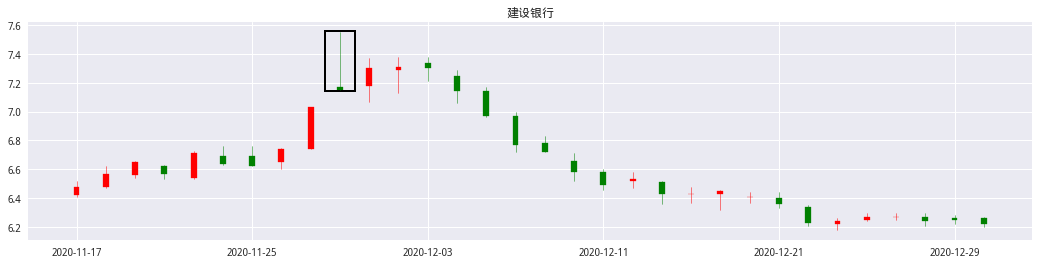

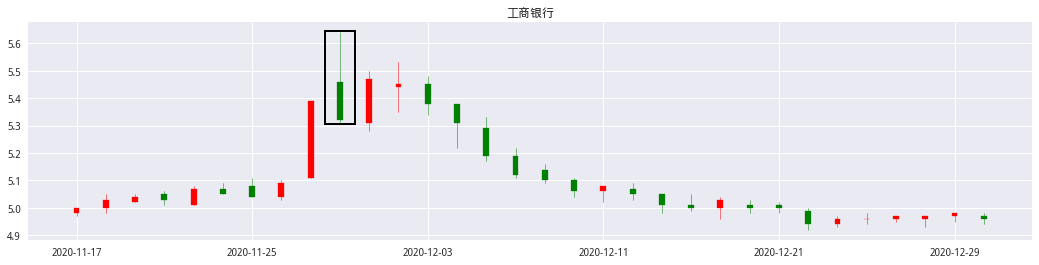

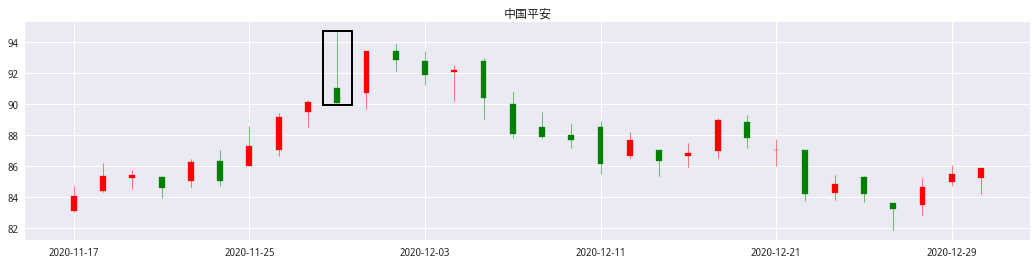

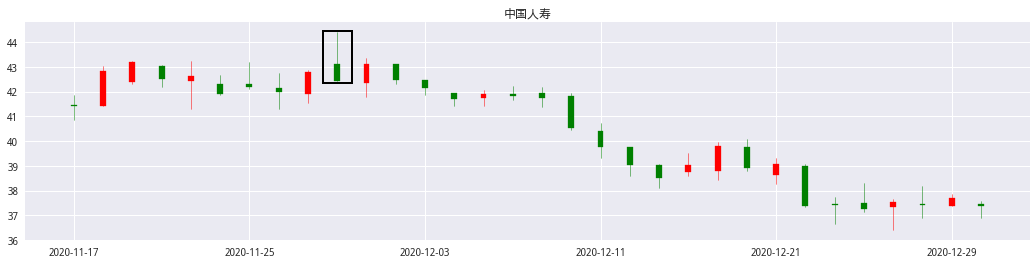

In [55]:
# 查看因子值最大的5只股票在因子计算日当日的K线形态
watch_date = datetime.date(2020,11,30)
target_col = 'UBL'
stocks = UBL_df.loc[watch_date,target_col].nsmallest(5).index.tolist()

beginDt = tdaysoffset(watch_date,-10)
endDt = tdaysoffset(watch_date,22) # 查看之后一个月的走向

for code in stocks:
    price = get_price(code,beginDt,endDt,fields=['close','open','high','low'],panel=False)
    code_name = get_security_info(code).display_name
    plot_candlestick(price,code_name,
                     pathpatch=get_mark_data(price,[watch_date.strftime('%Y-%m-%d')]))

In [24]:
def get_stlye_factor(codes: list, end_date: str) -> pd.DataFrame:
    '''获取聚宽风格因子'''
    factor_list = ['size', 'beta', 'momentum', 'residual_volatility',
                   'non_linear_size', 'book_to_price_ratio', 'liquidity',
                   'earnings_yield', 'growth', 'leverage']

    factor = get_factor_values(codes, factor_list, end_date=end_date, count=1)

    df = pd.concat((df.iloc[-1] for df in factor.values()),axis=1)
    df.columns = list(factor.keys())

    return df

In [25]:
# 获取聚宽风格因子
style_factor = UBL_df.groupby(level='date').apply(lambda x:
       get_stlye_factor(x.index.get_level_values(1).tolist(), end_date=x.name))

data = pd.concat((UBL_df,style_factor),axis=1)

In [26]:
#构建计算横截面因子载荷相关系数均值函数
def get_relations(datas: pd.DataFrame) -> pd.DataFrame:
    '''计算因子截面相关系数平均数'''
    relations = 0
    for trade,d in datas.groupby(level='date'):
        
        relations += d.corr()

    relations_mean = relations / len(datas.index.levels[0])

    return relations_mean

In [27]:
# 绘制因子正交前的相关性的热力图
fig = plt.figure(figsize=(26, 18))
# 计算相关性矩阵
relations = get_relations(data[[col for col in data if col!='next_ret']])

cm = sns.light_palette("red", as_cmap=True)

(relations.iloc[:,0].to_frame('UBL因子').style.background_gradient(cmap=cm)
                                        .format('{:.2%}'))

,UBL因子
UBL,100.00%
leverage,-11.83%
momentum,-6.18%
residual_volatility,9.00%
earnings_yield,-14.12%
beta,7.09%
growth,-5.42%
liquidity,3.32%
non_linear_size,18.91%
size,-27.89%


<Figure size 1872x1296 with 0 Axes>

## 纯净UBL因子

将UBL因子对11个风格和28个申万行业一级虚拟变量进行回归,将残差作为选股因子即**纯净UBL因子**

In [28]:
# 获取所属行业
def get_stock_ind(securities:list,watch_date:str,level:str='sw_l1',method:str='industry_code')->pd.Series:
    
    '''
    获取行业
    --------
        securities:股票列表
        watch_date:查询日期
        level:查询股票所属行业级别
        method:返回行业名称or代码
    '''
    
    indusrty_dict = get_industry(securities, watch_date)

    indusrty_ser = pd.Series({k: v.get(level, {method: np.nan})[
                             method] for k, v in indusrty_dict.items()})
    
    indusrty_ser.name = method.upper()
    
    return indusrty_ser

In [29]:
# 获取行业因子
data['industry'] = data.groupby(level='date').apply(
    lambda x: get_stock_ind(x.index.get_level_values(1).tolist(), x.name))

data_all = pd.get_dummies(data,columns=['industry'])

In [30]:
# 丢弃缺失值
data_all = data_all.dropna(subset=['UBL'])
# 缺失值填充为0，不太严谨的操作
data_all = data_all.fillna(0)

In [31]:
# 获取残差
def get_resid(df:pd.DataFrame,y:str,x:list)->pd.Series:
    '''计算残差'''
    result = sm.OLS(df[y],df[x]).fit()
    return result.resid

In [32]:
select_col = [
    col for col in data_all.columns if col not in ['next_ret', 'UBL']]

data_all['resid_ubl'] = data_all.groupby(
    level='date', group_keys=False).apply(get_resid, y='UBL', x=select_col)

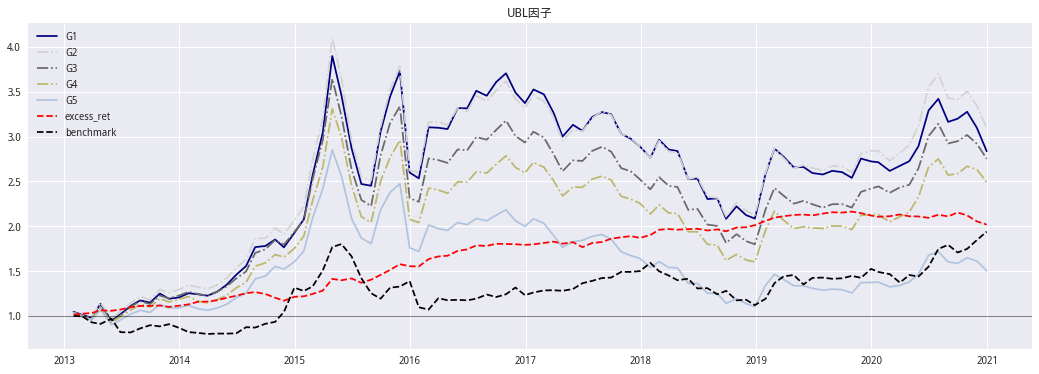

In [33]:
# 因子净值
residUBLCum = add_benchmark(data_all[['resid_ubl','next_ret']],'000300.XSHG','resid_ubl')
plot_nav(residUBLCum,'UBL因子')

In [34]:
# 纯净UBL因子风险指标
(Strategy_performance(residUBLCum.pct_change()).style.format('{:.2%}')
                                      .set_caption('多空组合风险指标'))

,G1,G2,G3,G4,G5,benchmark,excess_ret
年化收益率,13.28%,14.59%,12.97%,11.65%,4.82%,8.63%,8.98%
波动率,31.60%,31.18%,29.94%,28.89%,27.75%,23.21%,6.77%
夏普,55.52%,59.72%,56.17%,53.04%,30.99%,47.58%,132.05%
最大回撤,-46.57%,-48.70%,-50.65%,-51.58%,-61.30%,-40.56%,-7.57%
IR,5.24%,6.15%,4.82%,3.68%,-2.13%,nan%,-2.61%
Alpha,14.94%,16.08%,14.34%,12.76%,6.45%,nan%,8.49%


Information Analysis


,22
IC Mean,-0.028
IC Std.,0.062
Risk-Adjusted IC,-0.455
t-stat(IC),-4.458
p-value(IC),0.000
IC Skew,-0.141
IC Kurtosis,-0.417


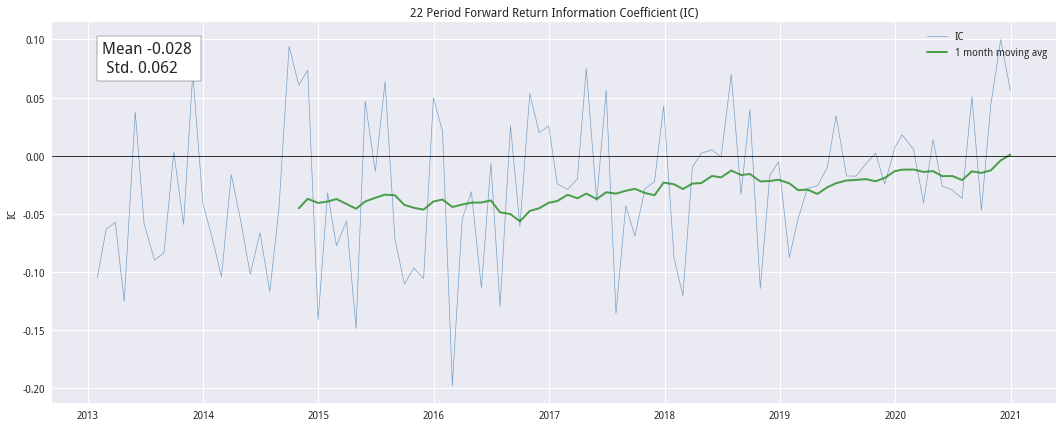

In [35]:
# 纯净UBL因子IC
resid_ubl = data_all[['resid_ubl','next_ret']].copy()
resid_ubl.rename(columns={'resid_ubl':'factor','next_ret':22},inplace=True)
ic = perf.factor_information_coefficient(resid_ubl)

plotting.plot_information_table(ic)
plotting.plot_ic_ts(ic);

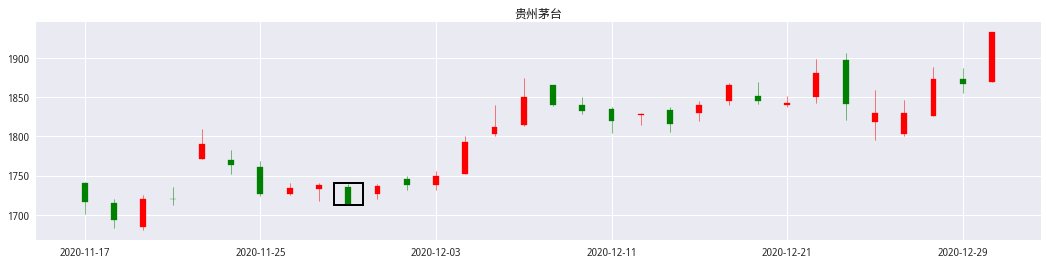

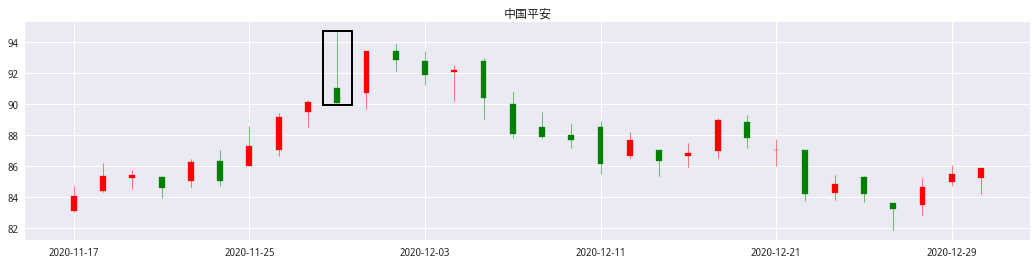

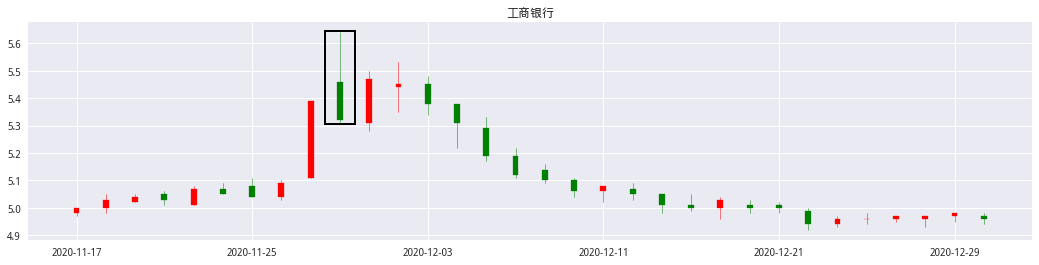

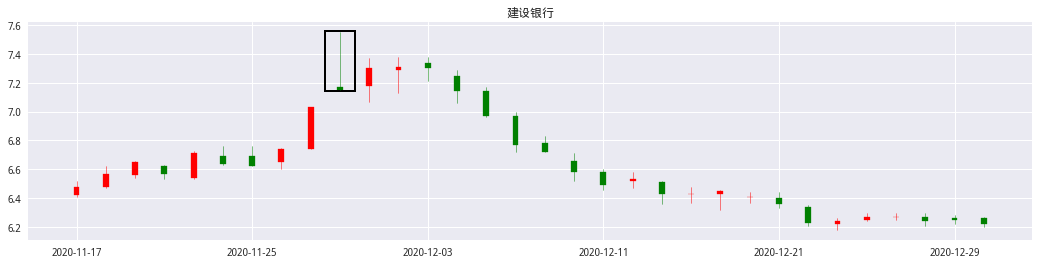

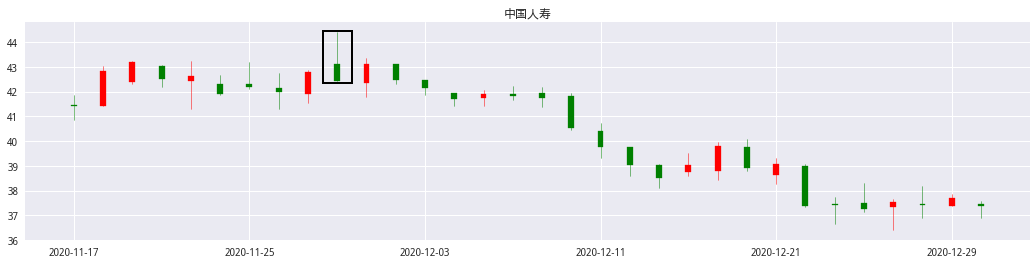

In [57]:
# 查看因子值最大的5只股票在因子计算日当日的K线形态
watch_date = datetime.date(2020,11,30)
target_col = 'resid_ubl'
stocks = data_all.loc[watch_date,target_col].nsmallest(5).index.tolist()

beginDt = tdaysoffset(watch_date,-10)
endDt = tdaysoffset(watch_date,22) # 查看之后一个月的走向

for code in stocks:
    price = get_price(code,beginDt,endDt,fields=['close','open','high','low'],panel=False)
    code_name = get_security_info(code).display_name
    plot_candlestick(price,code_name,
                     pathpatch=get_mark_data(price,[watch_date.strftime('%Y-%m-%d')]))